In [1]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from skimage.feature import hog

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/CO3519Assignment1/haarcascade_frontalface_default.xml")

def load_and_detect_faces(folder_path):
  images = []
  labels = []
  # Iterates through emotion subfolders
  for label in os.listdir(folder_path):
    label_path = os.path.join(folder_path, label)
    if os.path.isdir(label_path):
      # Iterates through image files
      for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          # Detects faces in the image
          faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
          for(x, y, w, h) in faces:
            face_region = img[y:y+h, x:x+w]
            images.append(face_region)
            labels.append(label)
  return images, labels

train_folder_path = "/content/drive/MyDrive/CO3519Assignment1/JAFFE-[70,30]/train"
test_folder_path = "/content/drive/MyDrive/CO3519Assignment1/JAFFE-[70,30]/test"

X_train, y_train = load_and_detect_faces(train_folder_path)
X_test, y_test = load_and_detect_faces(test_folder_path)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def preprocess_images(images):
  preprocessed_images = []
  for img in images:
    img = cv2.equalizeHist(img)
    preprocessed_images.append(img)
  return preprocessed_images

def extract_hog_features(images):
  hog_features = []
  for img in images:
    # Resizes image
    img = cv2.resize(img, (64, 64))
    # Computes HOG features
    features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)
    hog_features.append(features)
  return np.array(hog_features)

# Extracts features for training and test data
X_train_features = extract_hog_features(X_train)
X_test_features = extract_hog_features(X_test)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Creates SVM classifier pipeline
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced'))

# Trains the SVM classifier
svm_classifier.fit(X_train_features, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, class_weight='balanced'))])

In [6]:
y_pred = svm_classifier.predict(X_test_features)

# Calculates accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(len(y_test))

# Calculates the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 74.55%
55
[[9 0 0 0 0 0]
 [1 9 0 0 0 0]
 [0 3 6 0 0 0]
 [0 3 0 6 0 0]
 [2 1 0 1 5 0]
 [0 3 0 0 0 6]]


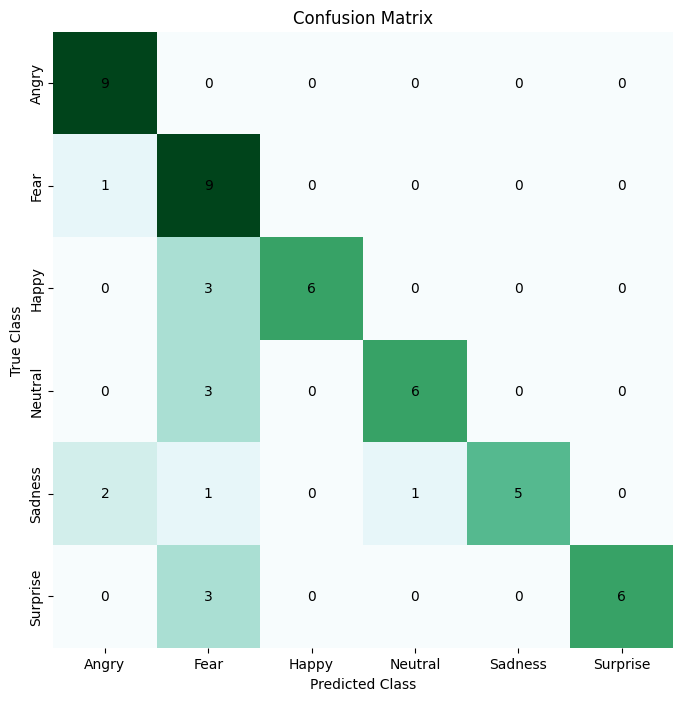

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

class_names = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

# Brings forward the confusion matrix to this code section
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculates confusion matrix percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Sets up plot figure
plt.figure(figsize=(8, 8))
# Creates a heatmap of the confusion matrix
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn",
                 xticklabels=class_names, yticklabels=class_names, cbar=False)

# Adds numerical annotations to each cell
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j + 0.5, i + 0.5, f'{count}',
                ha="center", va="center", color="black", fontsize=10)

# Labels and displays the plot
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

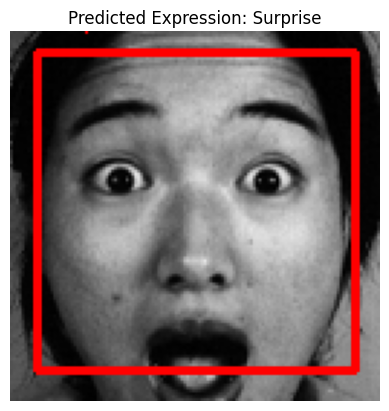

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initializes face detector
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/CO3519Assignment1/haarcascade_frontalface_default.xml')

def preprocess_and_extract_features(face_img):
    face_img = cv2.resize(face_img, (64, 64))

    features = hog(face_img, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)

    return features.reshape(1, -1)

def predict_emotion(image_path, model):
    # Loads the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or could not be loaded.")

    # Converts images to true greyscale
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detects faces
    faces = face_cascade.detectMultiScale(
        grey_img,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    # Iterates through each detected face
    for (x, y, w, h) in faces:

        face_region = grey_img[y:y+h, x:x+w]

        # Preprocesses and extracts features
        features = preprocess_and_extract_features(face_region)

        # Predicts the emotion
        predicted_expression = model.predict(features)[0]

        # Draws a rectangle around the face
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2);

        # Adds predicted emotion text
        cv2.putText(
            img,
            predicted_expression,
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.3,
            (255, 0, 0),
            2
        )

    # Displays the image
    plt.imshow(img);
    plt.title(f"Predicted Expression: {predicted_expression}");
    plt.axis('off'); # Hides axis
    plt.show();


# Defines path to a test image
image_path = "/content/drive/MyDrive/CO3519Assignment1/testimages/25.tiff"
# Runs emotion prediction on the test image
predict_emotion(image_path, svm_classifier)